# TTT4185 Machine learning for Speech technology

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

We will also be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

### Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.

(a) Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

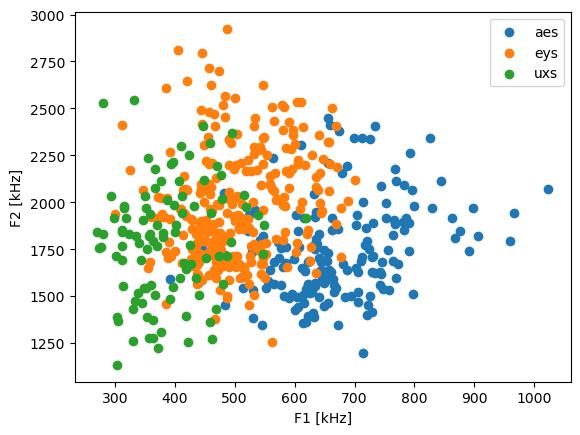

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Extract vowels
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']

aes_test = test[test["Phoneme"] == 'ae']
eys_test = test[test["Phoneme"] == 'ey']
uxs_test = test[test["Phoneme"] == 'ux']

# Plotting here
plt.scatter(aes.F1*1000, aes.F2*1000)
plt.scatter(eys.F1*1000, eys.F2*1000)
plt.scatter(uxs.F1*1000, uxs.F2*1000)
plt.legend(["aes", "eys", "uxs"])
plt.xlabel("F1 [kHz]")
plt.ylabel("F2 [kHz]")
plt.show()

There is a significant overlap between all the classes, but the 'eys' and 'uxs' are the phonemes with the most overlap across the three classes. Therefore, it is reasonable to assume that these two are the most difficult to distinguish from eachother.

(b) Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

Note:

Since we know / assume that the distribution is a Gaussian, the parameters to be estimated is the mean and the variance / covariance-matrix for each of the three classes. 

The classifier will be the posterior distributions, where we classify as the maximum of these. Thus we need to find the p(c|x) and then classify according to the maximum of these.

In [2]:
prior_aes = len(aes)/(len(aes)+len(eys)+len(uxs))
prior_eys = len(eys)/(len(aes)+len(eys)+len(uxs))
prior_uxs = len(uxs)/(len(aes)+len(eys)+len(uxs))

In [3]:
means_f1f2 = [np.mean(1000*aes[['F1', 'F2']].to_numpy(), axis=0), np.mean(1000*eys[['F1', 'F2']].to_numpy(), axis=0), np.mean(1000*uxs[['F1', 'F2']].to_numpy(), axis=0)]

covs_f1f2 = [np.cov(1000*aes[['F1', 'F2']].to_numpy(), rowvar=False), np.cov(1000*eys[['F1', 'F2']].to_numpy(), rowvar=False), np.cov(1000*uxs[['F1', 'F2']].to_numpy(), rowvar=False)]

We will use p(c|x) to classify. For each class, this can be computed using the Bayes rule, where we need to compute the likelihood and the prior. The likelihood is the probability of observing the data given the class, and the prior is the probability of observing the class. The likelihood is computed using the Gaussian distribution, and the prior is computed using the number of observations of each class. Since p(x) is equal for all classes, we can ignore it.

We then use the maximum of the posteriors to classify.

In [4]:
import scipy.stats

def findModels(mean, cov, prior):
    return [scipy.stats.multivariate_normal(mean, cov), prior]

# Models is an array which contains the mean, covariance and prior for each class
def classify(point, models):
    probabilities = []
    for model in models:
        probabilities.append(model[0].pdf(point)*model[1])
    return np.argmax(probabilities)

def getConfusionMatrix(data, models):
    confusionMatrix = np.zeros((3,3))

    for i in range(len(data)):
        for point in data[i]:
            confusionMatrix[i][classify(point, models)] += 1

    return confusionMatrix

models_f1f2 = [
    findModels(means_f1f2[0], covs_f1f2[0], prior_aes),  
    findModels(means_f1f2[1], covs_f1f2[1], prior_eys),
    findModels(means_f1f2[2], covs_f1f2[2], prior_uxs)
    ]

test_data_f1f2 = [(aes_test[['F1', 'F2']]*1000).to_numpy(), (eys_test[['F1', 'F2']]*1000).to_numpy(), (uxs_test[['F1', 'F2']]*1000).to_numpy()]

confusionMatrix_f1f2 = getConfusionMatrix(test_data_f1f2, models_f1f2)
print(confusionMatrix_f1f2)

[[80. 24.  1.]
 [13. 97.  4.]
 [ 1. 28. 23.]]


As we can see, the classifier is able to classify 'ae' and 'ey' well, but 'ux' is most often classified as 'ey'. This is in line with our expectations from the scatter plot if one also considers the priors.

(c) To visualize the classes models and the classifier created in (b), plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$, by using the following function.

In [5]:
import scipy.stats

def plotGaussian(mean, cov, color, ax):
    """ 
        Creates a contour plot for a bi-variate normal distribution
        
        mean: numpy array 2x1 with mean vector
        cov: numpy array 2x2 with covarince matrix
        color: name of color for the plot (see https://matplotlib.org/stable/gallery/color/named_colors.html)
        ax: axis handle where the plot is drawn (can for example be returned by plt.gca() or plt.subplots())
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]
    xy = np.dstack((x, y))
    mvn = scipy.stats.multivariate_normal(mean, cov)
    lik = mvn.pdf(xy)
    ax.contour(x,y,lik,colors=color)

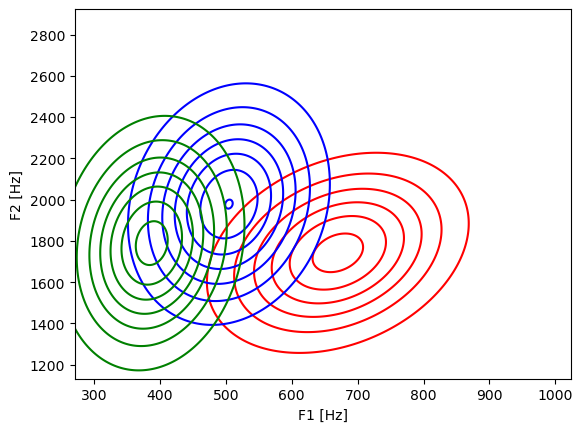

In [6]:
fig1, ax1 = plt.subplots()

ax1.set_xlim(1000*np.min([np.min(aes[['F1']]), np.min(eys[['F1']]), np.min(uxs[['F1']])]), 1000*np.max([np.max(aes[['F1']]), np.max(eys[['F1']]), np.max(uxs[['F1']])]))
ax1.set_ylim(1000*np.min([np.min(aes[['F2']]), np.min(eys[['F2']]), np.min(uxs[['F2']])]), 1000*np.max([np.max(aes[['F2']]), np.max(eys[['F2']]), np.max(uxs[['F2']])]))

# ax1.set_xlim(150, 1000)
# ax1.set_ylim(1000, 2700)

ax1.set_xlabel("F1 [Hz]")
ax1.set_ylabel("F2 [Hz]")

plotGaussian(means_f1f2[0], covs_f1f2[0], 'r', ax1)
plotGaussian(means_f1f2[1], covs_f1f2[1], 'b', ax1)
plotGaussian(means_f1f2[2], covs_f1f2[2], 'g', ax1)

ae: red

ey: blue

ux: green

As before, the overlap between the ey and ux phoneme is larger than their overlap with the ae phoneme.

*Try:* Plot the decision regions for the Bayesian classifier. Tips: Calculate the posterior for each class, use the `numpy.argmax` function to get the decision regions, and `matplotlib.pyplot.contourf` to plot them.

In [7]:
# First getting a list of all the points in the plot
F1Lim = [1000*np.min([np.min(aes['F1']), np.min(eys['F1']), np.min(uxs['F1'])]),
        1000*np.max([np.max(aes['F1']), np.max(eys['F1']), np.max(uxs['F1'])])]
F2Lim = [1000*np.min([np.min(aes['F2']), np.min(eys['F2']), np.min(uxs['F2'])]),
        1000*np.max([np.max(aes['F2']), np.max(eys['F2']), np.max(uxs['F2'])])]

F1s, F2s = np.mgrid[F1Lim[0]:F1Lim[1]:(F1Lim[1]-F1Lim[0])/500.0, F2Lim[0]:F2Lim[1]:(F2Lim[1]-F2Lim[0])/500.0]
f1f2 = np.dstack((F1s, F2s))

# Then we need to get the posterior probabilities for each point
p_posterior_aes = prior_aes*scipy.stats.multivariate_normal(means_f1f2[0], covs_f1f2[0]).pdf(f1f2)
p_posterior_eys = prior_eys*scipy.stats.multivariate_normal(means_f1f2[1], covs_f1f2[1]).pdf(f1f2)
p_posterior_uxs = prior_uxs*scipy.stats.multivariate_normal(means_f1f2[2], covs_f1f2[2]).pdf(f1f2)

posteriors = [p_posterior_aes, p_posterior_eys, p_posterior_uxs]

# Find the indices where each of the posterior is the largest
aes_indices = np.where(p_posterior_aes == np.amax(posteriors, axis=0))
eys_indices = np.where(p_posterior_eys == np.amax(posteriors, axis=0))
uxs_indices = np.where(p_posterior_uxs == np.amax(posteriors, axis=0))

f1f2_aes_dr = np.dstack((F1s[aes_indices], F2s[aes_indices]))
f1f2_eys_dr = np.dstack((F1s[eys_indices], F2s[eys_indices]))
f1f2_uxs_dr = np.dstack((F1s[uxs_indices], F2s[uxs_indices]))

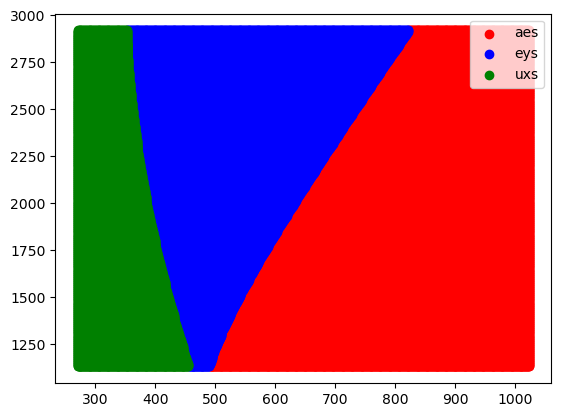

In [8]:
# Plotting decision regions

plt.scatter(np.transpose(f1f2_aes_dr)[0], np.transpose(f1f2_aes_dr)[1], color='r', marker='o', label='aes')
plt.scatter(np.transpose(f1f2_eys_dr)[0], np.transpose(f1f2_eys_dr)[1], color='b', marker='o', label='eys')
plt.scatter(np.transpose(f1f2_uxs_dr)[0], np.transpose(f1f2_uxs_dr)[1], color='g', marker='o', label='uxs')
plt.legend(['aes', 'eys', 'uxs'])
plt.show()

(d) Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

This has been calculated above

In [9]:
print(confusionMatrix_f1f2)

[[80. 24.  1.]
 [13. 97.  4.]
 [ 1. 28. 23.]]


(e) Extend your classifier to include the features "F1"-"F4" and compare the results with those in (d). Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

In [10]:
means_f1f2f3f4 = [np.mean(1000*aes[['F1', 'F2', 'F3', 'F4']].to_numpy(), axis=0), np.mean(1000*eys[['F1', 'F2', 'F3', 'F4']].to_numpy(), axis=0), np.mean(1000*uxs[['F1', 'F2', 'F3', 'F4']].to_numpy(), axis=0)]

covs_f1f2f3f4 = [np.cov(1000*aes[['F1', 'F2', 'F3', 'F4']].to_numpy(), rowvar=False), np.cov(1000*eys[['F1', 'F2', 'F3', 'F4']].to_numpy(), rowvar=False), np.cov(1000*uxs[['F1', 'F2', 'F3', 'F4']].to_numpy(), rowvar=False)]

models_f1f2f3f4 = [
    findModels(means_f1f2f3f4[0], covs_f1f2f3f4[0], prior_aes),  
    findModels(means_f1f2f3f4[1], covs_f1f2f3f4[1], prior_eys),
    findModels(means_f1f2f3f4[2], covs_f1f2f3f4[2], prior_uxs)
    ]

test_data_f1f2f3f4 = [(aes_test[['F1', 'F2', 'F3', 'F4']]*1000).to_numpy(), (eys_test[['F1', 'F2', 'F3', 'F4']]*1000).to_numpy(), (uxs_test[['F1', 'F2', 'F3', 'F4']]*1000).to_numpy()]

confusionMatrix_f1f2f3f4 = getConfusionMatrix(test_data_f1f2f3f4, models_f1f2f3f4)

print(confusionMatrix_f1f2f3f4)

[[82. 21.  2.]
 [13. 98.  3.]
 [ 2. 25. 25.]]


When introducing the features F3 and F4 as well, the performance increases. This might be because the classes are more separated in the higher dimensions.

In [11]:
means_f1f2f3f4b1b2b3b4 = [np.mean(1000*aes[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), axis=0), np.mean(1000*eys[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), axis=0), np.mean(1000*uxs[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), axis=0)]

covs_f1f2f3f4b1b2b3b4 = [np.cov(1000*aes[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), rowvar=False), np.cov(1000*eys[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), rowvar=False), np.cov(1000*uxs[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), rowvar=False)]

models_f1f2f3f4b1b2b3b4 = [
    findModels(means_f1f2f3f4b1b2b3b4[0], covs_f1f2f3f4b1b2b3b4[0], prior_aes),  
    findModels(means_f1f2f3f4b1b2b3b4[1], covs_f1f2f3f4b1b2b3b4[1], prior_eys),
    findModels(means_f1f2f3f4b1b2b3b4[2], covs_f1f2f3f4b1b2b3b4[2], prior_uxs)
    ]

test_data_f1f2f3f4b1b2b3b4 = [(aes_test[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']]*1000).to_numpy(), (eys_test[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']]*1000).to_numpy(), (uxs_test[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']]*1000).to_numpy()]

confusionMatrix_f1f2f3f4b1b2b3b4 = getConfusionMatrix(test_data_f1f2f3f4b1b2b3b4, models_f1f2f3f4b1b2b3b4)

print(confusionMatrix_f1f2f3f4b1b2b3b4)

[[82. 23.  0.]
 [13. 90. 11.]
 [ 3. 28. 21.]]


Performance goes down when adding B1, B2, B3 and B4. This can because of overlap between these features for the different classes. The performance can also be affected by 'the curse of dimensionality', which requires us to have more training data when we increase the number of dimensions.

(f) We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (e).

First a test using F1, F2, F3 and F4 only, then a test including B1, B2, B3 and B4

From the training data, we can estimate p(x|c,g), p(c), p(g), p(g|c), p(c|g) and p(c,g)

We can then use marginalization to get p(x|c) by summing over g. I.e., p(x|c) = p(x,g1|c) + p(x,g2|c) = p(x|c,g1)*p(g1) + p(x|c,g2)*p(g2)

We now want to classify using p(c|x,g) which can be found using:

p(c|x,g) = p(x|c,g)*p(c|g) / p(x|g)

Since p(x|g) doesn't help with the classification, we can ignore it and classify using p(x|c,g)*p(c|g)

To classify using p(x|c,g) as the likelihood, we just use the male training samples. The prior p(c|g) can be obtained using f. ex. for male 'aes': (#male aes)/(#total male phonemes)

In [12]:
aes_m = aes[aes['Gender'] == 'M']
aes_f = aes[aes['Gender'] == 'F']

eys_m = eys[eys['Gender'] == 'M']
eys_f = eys[eys['Gender'] == 'F']

uxs_m = uxs[uxs['Gender'] == 'M']
uxs_f = uxs[uxs['Gender'] == 'F']

prior_aes_m = len(aes_m)/(len(aes_m) + len(eys_m) + len(uxs_m))
prior_eys_m = len(eys_m)/(len(aes_m) + len(eys_m) + len(uxs_m))
prior_uxs_m = len(uxs_m)/(len(aes_m) + len(eys_m) + len(uxs_m))

prior_aes_f = len(aes_f)/(len(aes_f) + len(eys_f) + len(uxs_f))
prior_eys_f = len(eys_f)/(len(aes_f) + len(eys_f) + len(uxs_f))
prior_uxs_f = len(uxs_f)/(len(aes_f) + len(eys_f) + len(uxs_f))

In [13]:
means_f1f2f3f4_m = [np.mean(1000*aes_m[['F1', 'F2', 'F3', 'F4']].to_numpy(), axis=0), np.mean(1000*eys_m[['F1', 'F2', 'F3', 'F4']].to_numpy(), axis=0), np.mean(1000*uxs_m[['F1', 'F2', 'F3', 'F4']].to_numpy(), axis=0)]
covs_f1f2f3f4_m = [np.cov(1000*aes_m[['F1', 'F2', 'F3', 'F4']].to_numpy(), rowvar=False), np.cov(1000*eys_m[['F1', 'F2', 'F3', 'F4']].to_numpy(), rowvar=False), np.cov(1000*uxs_m[['F1', 'F2', 'F3', 'F4']].to_numpy(), rowvar=False)]

means_f1f2f3f4_f = [np.mean(1000*aes_f[['F1', 'F2', 'F3', 'F4']].to_numpy(), axis=0), np.mean(1000*eys_f[['F1', 'F2', 'F3', 'F4']].to_numpy(), axis=0), np.mean(1000*uxs_f[['F1', 'F2', 'F3', 'F4']].to_numpy(), axis=0)]
covs_f1f2f3f4_f = [np.cov(1000*aes_f[['F1', 'F2', 'F3', 'F4']].to_numpy(), rowvar=False), np.cov(1000*eys_f[['F1', 'F2', 'F3', 'F4']].to_numpy(), rowvar=False), np.cov(1000*uxs_f[['F1', 'F2', 'F3', 'F4']].to_numpy(), rowvar=False)]

models_f1f2f3f4_m = [
    findModels(means_f1f2f3f4_m[0], covs_f1f2f3f4_m[0], prior_aes_m),
    findModels(means_f1f2f3f4_m[1], covs_f1f2f3f4_m[1], prior_eys_m),
    findModels(means_f1f2f3f4_m[2], covs_f1f2f3f4_m[2], prior_uxs_m)
    ]

models_f1f2f3f4_f = [
    findModels(means_f1f2f3f4_f[0], covs_f1f2f3f4_f[0], prior_aes_f),
    findModels(means_f1f2f3f4_f[1], covs_f1f2f3f4_f[1], prior_eys_f),
    findModels(means_f1f2f3f4_f[2], covs_f1f2f3f4_f[2], prior_uxs_f)
    ]

aes_test_m = aes_test[aes_test['Gender'] == 'M']
aes_test_f = aes_test[aes_test['Gender'] == 'F']

eys_test_m = eys_test[eys_test['Gender'] == 'M']
eys_test_f = eys_test[eys_test['Gender'] == 'F']

uxs_test_m = uxs_test[uxs_test['Gender'] == 'M']
uxs_test_f = uxs_test[uxs_test['Gender'] == 'F']

test_data_m_f1f2f3f4 = [(aes_test_m[['F1', 'F2', 'F3', 'F4']]*1000).to_numpy(), (eys_test_m[['F1', 'F2', 'F3', 'F4']]*1000).to_numpy(), (uxs_test_m[['F1', 'F2', 'F3', 'F4']]*1000).to_numpy()]
test_data_f_f1f2f3f4 = [(aes_test_f[['F1', 'F2', 'F3', 'F4']]*1000).to_numpy(), (eys_test_f[['F1', 'F2', 'F3', 'F4']]*1000).to_numpy(), (uxs_test_f[['F1', 'F2', 'F3', 'F4']]*1000).to_numpy()]

confusionMatrix_f1f2f3f4_g = getConfusionMatrix(test_data_m_f1f2f3f4, models_f1f2f3f4_m)
confusionMatrix_f1f2f3f4_g += getConfusionMatrix(test_data_f_f1f2f3f4, models_f1f2f3f4_f)

print(confusionMatrix_f1f2f3f4_g)

[[ 86.  18.   1.]
 [ 11. 100.   3.]
 [  3.  16.  33.]]


When including the genders, the performance goes up - as expected.

In [14]:
means_f1f2f3f4b1b2b3b4_m = [np.mean(1000*aes_m[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), axis=0), np.mean(1000*eys_m[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), axis=0), np.mean(1000*uxs_m[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), axis=0)]
covs_f1f2f3f4b1b2b3b4_m = [np.cov(1000*aes_m[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), rowvar=False), np.cov(1000*eys_m[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), rowvar=False), np.cov(1000*uxs_m[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), rowvar=False)]

means_f1f2f3f4b1b2b3b4_f = [np.mean(1000*aes_f[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), axis=0), np.mean(1000*eys_f[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), axis=0), np.mean(1000*uxs_f[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), axis=0)]
covs_f1f2f3f4b1b2b3b4_f = [np.cov(1000*aes_f[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), rowvar=False), np.cov(1000*eys_f[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), rowvar=False), np.cov(1000*uxs_f[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']].to_numpy(), rowvar=False)]

models_f1f2f3f4b1b2b3b4_m = [
    findModels(means_f1f2f3f4b1b2b3b4_m[0], covs_f1f2f3f4b1b2b3b4_m[0], prior_aes_m),
    findModels(means_f1f2f3f4b1b2b3b4_m[1], covs_f1f2f3f4b1b2b3b4_m[1], prior_eys_m),
    findModels(means_f1f2f3f4b1b2b3b4_m[2], covs_f1f2f3f4b1b2b3b4_m[2], prior_uxs_m)
]

models_f1f2f3f4b1b2b3b4_f = [
    findModels(means_f1f2f3f4b1b2b3b4_f[0], covs_f1f2f3f4b1b2b3b4_f[0], prior_aes_f),
    findModels(means_f1f2f3f4b1b2b3b4_f[1], covs_f1f2f3f4b1b2b3b4_f[1], prior_eys_f),
    findModels(means_f1f2f3f4b1b2b3b4_f[2], covs_f1f2f3f4b1b2b3b4_f[2], prior_uxs_f)
]

test_data_m_f1f2f3f4b1b2b3b4 = [(aes_test_m[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']]*1000).to_numpy(), (eys_test_m[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']]*1000).to_numpy(), (uxs_test_m[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']]*1000).to_numpy()]
test_data_f_f1f2f3f4b1b2b3b4 = [(aes_test_f[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']]*1000).to_numpy(), (eys_test_f[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']]*1000).to_numpy(), (uxs_test_f[['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']]*1000).to_numpy()]

confusionMatrix_f1f2f3f4b1b2b3b4_g = getConfusionMatrix(test_data_m_f1f2f3f4b1b2b3b4, models_f1f2f3f4b1b2b3b4_m)
confusionMatrix_f1f2f3f4b1b2b3b4_g += getConfusionMatrix(test_data_f_f1f2f3f4b1b2b3b4, models_f1f2f3f4b1b2b3b4_f)

print(confusionMatrix_f1f2f3f4b1b2b3b4_g)

[[85. 20.  0.]
 [15. 89. 10.]
 [ 3. 17. 32.]]


Again the performance goes down from when only using F1, F2, F3 and F4 and considering the gender. However, the performance is better than when not considering the gender and using F1-F4 and B1-B4.

(g) When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (f) using only diagonal covariance matrices and compare the results.

In [15]:
# Now we will have the same values as before, but the covariance in the models change

covs_f1f2f3f4_m_diag = [np.diag(np.diag(covs_f1f2f3f4_m[0])), np.diag(np.diag(covs_f1f2f3f4_m[1])), np.diag(np.diag(covs_f1f2f3f4_m[2]))]

covs_f1f2f3f4_f_diag = [np.diag(np.diag(covs_f1f2f3f4_f[0])), np.diag(np.diag(covs_f1f2f3f4_f[1])), np.diag(np.diag(covs_f1f2f3f4_f[2]))]

models_f1f2f3f4_m_diag = [
    findModels(means_f1f2f3f4_m[0], covs_f1f2f3f4_m_diag[0], prior_aes_m),
    findModels(means_f1f2f3f4_m[1], covs_f1f2f3f4_m_diag[1], prior_eys_m),
    findModels(means_f1f2f3f4_m[2], covs_f1f2f3f4_m_diag[2], prior_uxs_m)
    ]
    
models_f1f2f3f4_f_diag = [
    findModels(means_f1f2f3f4_f[0], covs_f1f2f3f4_f_diag[0], prior_aes_f),
    findModels(means_f1f2f3f4_f[1], covs_f1f2f3f4_f_diag[1], prior_eys_f),
    findModels(means_f1f2f3f4_f[2], covs_f1f2f3f4_f_diag[2], prior_uxs_f)
    ]

confusionMatrix_f1f2f3f4_g_diag = getConfusionMatrix(test_data_m_f1f2f3f4, models_f1f2f3f4_m_diag)
confusionMatrix_f1f2f3f4_g_diag += getConfusionMatrix(test_data_f_f1f2f3f4, models_f1f2f3f4_f_diag)

print(confusionMatrix_f1f2f3f4_g_diag)

[[82. 22.  1.]
 [14. 96.  4.]
 [ 1. 17. 34.]]


In [16]:
covs_f1f2f3f4b1b2b3b4_m_diag = [np.diag(np.diag(covs_f1f2f3f4b1b2b3b4_m[0])), np.diag(np.diag(covs_f1f2f3f4b1b2b3b4_m[1])), np.diag(np.diag(covs_f1f2f3f4b1b2b3b4_m[2]))]

covs_f1f2f3f4b1b2b3b4_f_diag = [np.diag(np.diag(covs_f1f2f3f4b1b2b3b4_f[0])), np.diag(np.diag(covs_f1f2f3f4b1b2b3b4_f[1])), np.diag(np.diag(covs_f1f2f3f4b1b2b3b4_f[2]))]

models_f1f2f3f4b1b2b3b4_m_diag = [
    findModels(means_f1f2f3f4b1b2b3b4_m[0], covs_f1f2f3f4b1b2b3b4_m_diag[0], prior_aes_m),
    findModels(means_f1f2f3f4b1b2b3b4_m[1], covs_f1f2f3f4b1b2b3b4_m_diag[1], prior_eys_m),
    findModels(means_f1f2f3f4b1b2b3b4_m[2], covs_f1f2f3f4b1b2b3b4_m_diag[2], prior_uxs_m)
    ]

models_f1f2f3f4b1b2b3b4_f_diag = [
    findModels(means_f1f2f3f4b1b2b3b4_f[0], covs_f1f2f3f4b1b2b3b4_f_diag[0], prior_aes_f),
    findModels(means_f1f2f3f4b1b2b3b4_f[1], covs_f1f2f3f4b1b2b3b4_f_diag[1], prior_eys_f),
    findModels(means_f1f2f3f4b1b2b3b4_f[2], covs_f1f2f3f4b1b2b3b4_f_diag[2], prior_uxs_f)
    ]

confusionMatrix_f1f2f3f4b1b2b3b4_g_diag = getConfusionMatrix(test_data_m_f1f2f3f4b1b2b3b4, models_f1f2f3f4b1b2b3b4_m_diag)
confusionMatrix_f1f2f3f4b1b2b3b4_g_diag += getConfusionMatrix(test_data_f_f1f2f3f4b1b2b3b4, models_f1f2f3f4b1b2b3b4_f_diag)

print(confusionMatrix_f1f2f3f4b1b2b3b4_g_diag)

[[88. 16.  1.]
 [19. 87.  8.]
 [ 2. 14. 36.]]


The performance when using F1, F2, F3 and F4 goes a bit down - but when also including B1, B2, B3 and B4, the performance goes up for 'aes' and 'uxs' and down for 'eys'. This might be because the covariance between the features is important for the 'eys' but not for the 'aes' and 'uxs'.

All in all, the performance is better when using the full covariance matrix, but the performance is not majorly affected by using the diagonal covariance matrix and it requires less computation / parameters. Hence only using the diagonal covariance matrix might be a good idea if we have a restriction on the number of parameters.

### Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short, we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

You can use or adapt the following functions to visualize the SVM decision regions and support vectors in 2D.

In [17]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

def Plot_SVM_decision_regions(clf,data,labels):
    '''
    This function is for plotting the decision area of SVM
    
    Args:
    - clf: SVM model
    - data: Data with two features
    - labels: Corresponding labels of the data
    '''
    phonemes = np.array(["ae","ey","ux"])
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(phonemes)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    sns.scatterplot(data[:,0],data[:,1],hue=labels)
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Decision Area of SVM')
    plt.show()

def Plot_Support_Vectors(clf,data):
    '''
    This function is for plotting the support vectors of the SVM model
    
    Args:
    - clf: SVM model
    - data: Data with two features
    '''
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    label_encoder = LabelEncoder()
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Support Vectors')
    plt.show()

(a) Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

In [18]:
from sklearn.svm import SVC

Cs = [0.1, 1, 10]

cls_0point1_linear = SVC(kernel='linear', C=Cs[0], decision_function_shape='ovo')
cls_1_linear = SVC(kernel='linear', C=Cs[1], decision_function_shape='ovo')
cls_10_linear = SVC(kernel='linear', C=Cs[2], decision_function_shape='ovo')

aes_train = train[train['Phoneme'] == 'ae']
eys_train = train[train['Phoneme'] == 'ey']
uxs_train = train[train['Phoneme'] == 'ux']

aes_test = test[test['Phoneme'] == 'ae']
eys_test = test[test['Phoneme'] == 'ey']
uxs_test = test[test['Phoneme'] == 'ux']

training_set = pd.concat([aes_train[['F1', 'F2']], eys_train[['F1', 'F2']], uxs_train[['F1', 'F2']]]).to_numpy()
training_labels = []
training_labels_phonemes = []

for i in range(len(aes_train)):
    training_labels.append(0)
    training_labels_phonemes.append('ae')
for i in range(len(eys_train)):
    training_labels.append(1)
    training_labels_phonemes.append('ey')
for i in range(len(uxs_train)):
    training_labels.append(2)
    training_labels_phonemes.append('ux')

testing_set = pd.concat([aes_test[['F1', 'F2']], eys_test[['F1', 'F2']], uxs_test[['F1', 'F2']]]).to_numpy()

In [19]:
cls_0point1_linear.fit(training_set, training_labels)
cls_1_linear.fit(training_set, training_labels)
cls_10_linear.fit(training_set, training_labels)
print() # Just to avoid printing the SVC object

In [20]:
from sklearn.metrics import accuracy_score

pred_0point1 = cls_0point1_linear.predict(testing_set)
pred_1 = cls_1_linear.predict(testing_set)
pred_10 = cls_10_linear.predict(testing_set)

# Getting the true labels for the testing data:

testing_labels = []
testing_labels_phonemes = []

for i in range(len(testing_set)):
    if i < len(aes_test):
        testing_labels.append(0)
        testing_labels_phonemes.append('ae')
    elif i < len(aes_test) + len(eys_test):
        testing_labels.append(1)
        testing_labels_phonemes.append('ey')
    else:
        testing_labels.append(2)
        testing_labels_phonemes.append('ux')
testing_labels = np.array(testing_labels)

print("Accuracy of C = 0.1: ", accuracy_score(testing_labels, pred_0point1))
print("Accuracy of C = 1: ", accuracy_score(testing_labels, pred_1))
print("Accuracy of C = 10: ", accuracy_score(testing_labels, pred_10))

Accuracy of C = 0.1:  0.5092250922509225
Accuracy of C = 1:  0.6789667896678967
Accuracy of C = 10:  0.7527675276752768


Accuray in problem 1:

F1, F2:                                                       0.74

F1, F2, F3, F4:                                               0.76

F1, F2, F3, F4, B1, B2, B3, B4:                               0.71

F1, F2, F3, F4 (with genders):                                0.81

F1, F2, F3, F4, B1, B2, B3, B4 (with genders):                0.76

F1, F2, F3, F4 (with genders, only diagonal):                 0.78

F1, F2, F3, F4, B1, B2, B3, B4 (with genders, only diagonal): 0.78

We can see that the classifier in problem 1 is generally better than the linear kernel SVM. However, the performance becomes close when the penalty term is 10.

In [21]:
from matplotlib.colors import ListedColormap

def PlotSVMDecisionRegions(clf, data, labels, title = "Decision Area of SVM"):
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()


    # ax.scatter(data[:,0], data[:,1], c=labels, cmap=plt.cm.ocean, edgecolors='k')
    sns.scatterplot(x=data[:,0], y=data[:,1], hue=labels, ax=ax, edgecolor='k', alpha=0.5)

    ax.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('F1')
    ax.set_ylabel('F2')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    plt.show()

def PlotSupportVectors(clf, data, labels, title = "Support Vectors"):
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # plt.figure(figsize=(10,6))
    plt.subplot()
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title(title)
    plt.show()

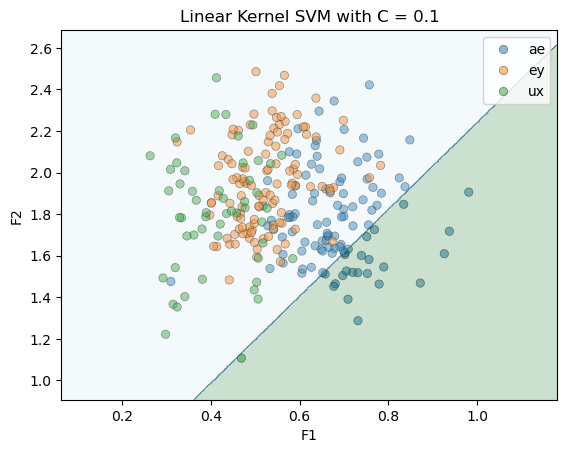

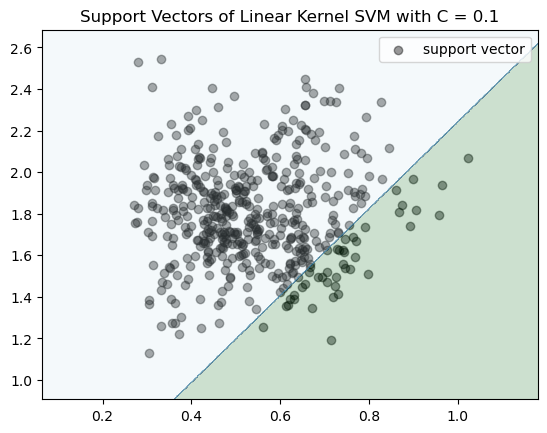

In [22]:
# Some plots of support vectors here:
PlotSVMDecisionRegions(cls_0point1_linear, testing_set, testing_labels_phonemes, title = "Linear Kernel SVM with C = 0.1")
PlotSupportVectors(cls_0point1_linear, testing_set, testing_labels_phonemes, title = "Support Vectors of Linear Kernel SVM with C = 0.1")

As predicted earlier, the 'eys' and 'uxs' are harder to separate.

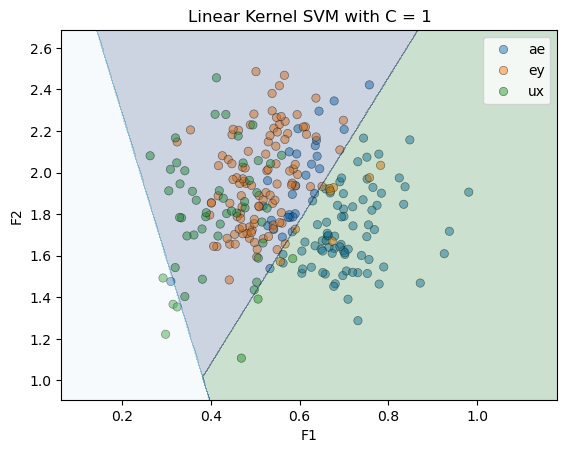

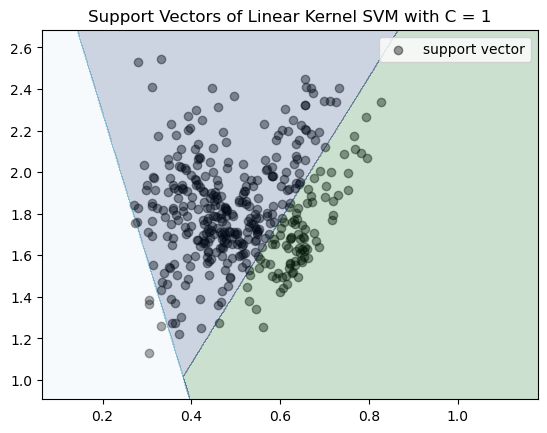

In [23]:
PlotSVMDecisionRegions(cls_1_linear, testing_set, testing_labels_phonemes, title = "Linear Kernel SVM with C = 1")
PlotSupportVectors(cls_1_linear, testing_set, testing_labels_phonemes, title = "Support Vectors of Linear Kernel SVM with C = 1")

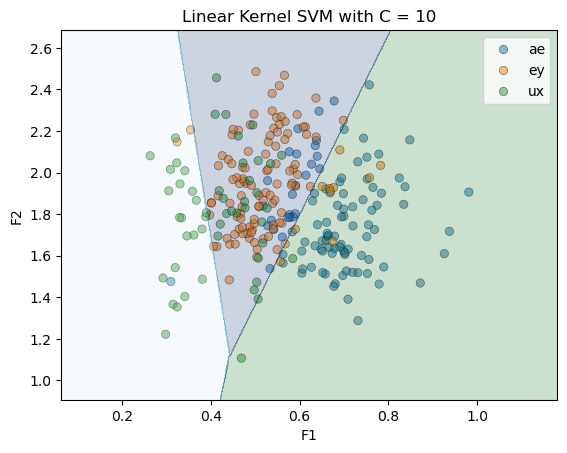

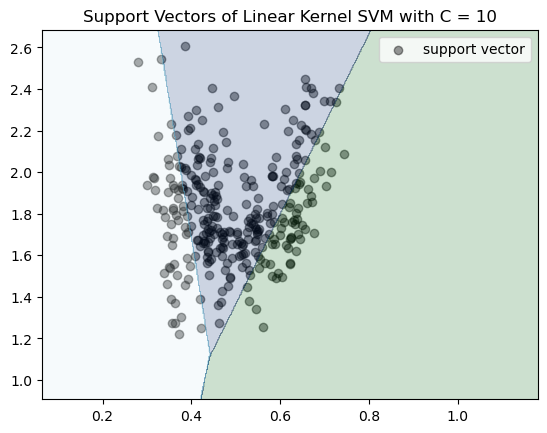

In [24]:
PlotSVMDecisionRegions(cls_10_linear, testing_set, testing_labels_phonemes, title = "Linear Kernel SVM with C = 10")
PlotSupportVectors(cls_10_linear, testing_set, testing_labels_phonemes, title = "Support Vectors of Linear Kernel SVM with C = 10")

(b) Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?

In [25]:
# Using C = 1 (default)
cls_rbf = SVC(kernel='rbf', C=Cs[1], decision_function_shape='ovo')
cls_poly = SVC(kernel='poly', C=Cs[1], decision_function_shape='ovo')
cls_sigmoid = SVC(kernel='sigmoid', C=Cs[1], decision_function_shape='ovo')

In [26]:
cls_rbf.fit(training_set, training_labels)
cls_poly.fit(training_set, training_labels)
cls_sigmoid.fit(training_set, training_labels)
print() # Just to avoid printing the SVC object

In [27]:
pred_rbf_training = cls_rbf.predict(training_set)
pred_poly_training = cls_poly.predict(training_set)
pred_sigmoid_training = cls_sigmoid.predict(training_set)

print("Using C = 1 on the training set")
print("Accuracy of RBF kernel on training data: ", accuracy_score(training_labels, pred_rbf_training))
print("Accuracy of Polynomial kernel on training data: ", accuracy_score(training_labels, pred_poly_training))
print("Accuracy of Sigmoid kernel on training data: ", accuracy_score(training_labels, pred_sigmoid_training))

Using C = 1 on the training set
Accuracy of RBF kernel on training data:  0.7787769784172662
Accuracy of Polynomial kernel on training data:  0.8111510791366906
Accuracy of Sigmoid kernel on training data:  0.5089928057553957


In [28]:
pred_rbf = cls_rbf.predict(testing_set)
pred_poly = cls_poly.predict(testing_set)
pred_sigmoid = cls_sigmoid.predict(testing_set)

print("Using C = 1 on the test set")
print("Accuracy of RBF on the test set: ", accuracy_score(testing_labels, pred_rbf))
print("Accuracy of Polynomial on the test set: ", accuracy_score(testing_labels, pred_poly))
print("Accuracy of Sigmoid on the test set: ", accuracy_score(testing_labels, pred_sigmoid))

Using C = 1 on the test set
Accuracy of RBF on the test set:  0.7011070110701108
Accuracy of Polynomial on the test set:  0.7564575645756457
Accuracy of Sigmoid on the test set:  0.42066420664206644


We can see that the RBF and polynomial kernel is an improvement from the linear kernel. At C = 1, the polynomial kernel is already matching the performance of the linear kernel at C = 10.

Plots of the decision regions and support vectors are shown below.

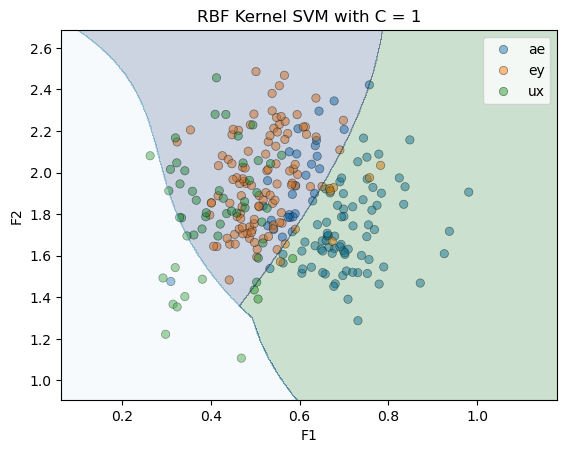

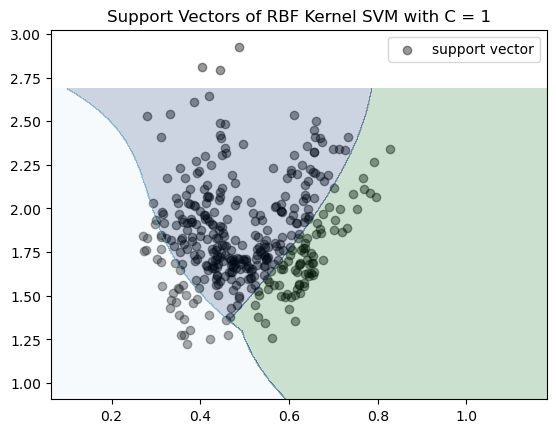

In [29]:
PlotSVMDecisionRegions(cls_rbf, testing_set, testing_labels_phonemes, title = "RBF Kernel SVM with C = 1")
PlotSupportVectors(cls_rbf, testing_set, testing_labels_phonemes, title = "Support Vectors of RBF Kernel SVM with C = 1")

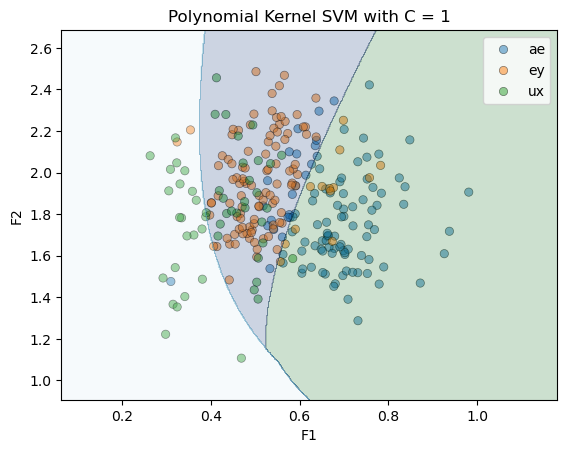

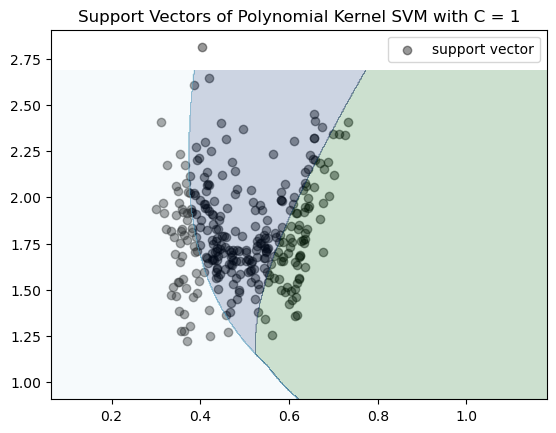

In [30]:
PlotSVMDecisionRegions(cls_poly, testing_set, testing_labels_phonemes, title = "Polynomial Kernel SVM with C = 1")
PlotSupportVectors(cls_poly, testing_set, testing_labels_phonemes, title = "Support Vectors of Polynomial Kernel SVM with C = 1")

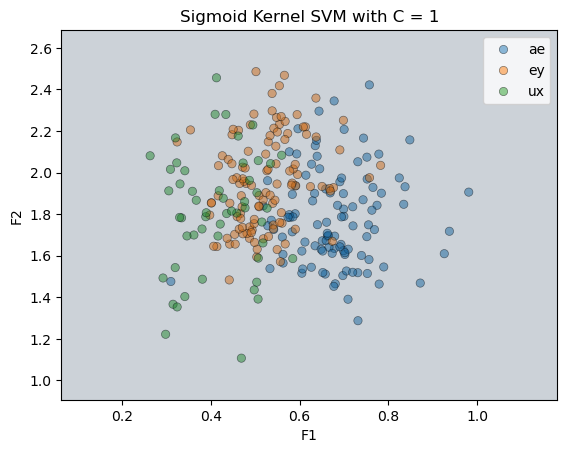

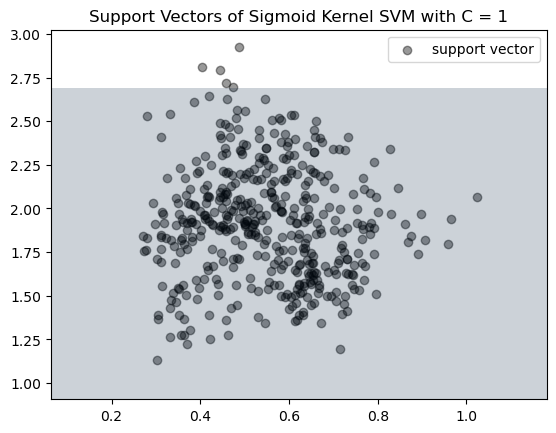

In [31]:
PlotSVMDecisionRegions(cls_sigmoid, testing_set, testing_labels_phonemes, title = "Sigmoid Kernel SVM with C = 1")
PlotSupportVectors(cls_sigmoid, testing_set, testing_labels_phonemes, title = "Support Vectors of Sigmoid Kernel SVM with C = 1")

Using a  poly  kernel with C =  0.1
Accuracy on the training set:  0.814748201438849
Accuracy on the test set:  0.7490774907749077


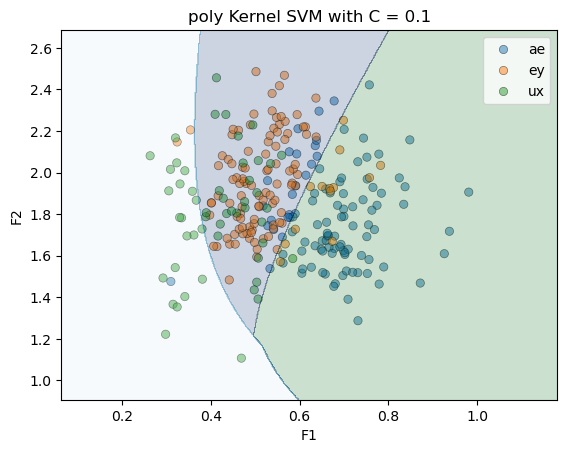

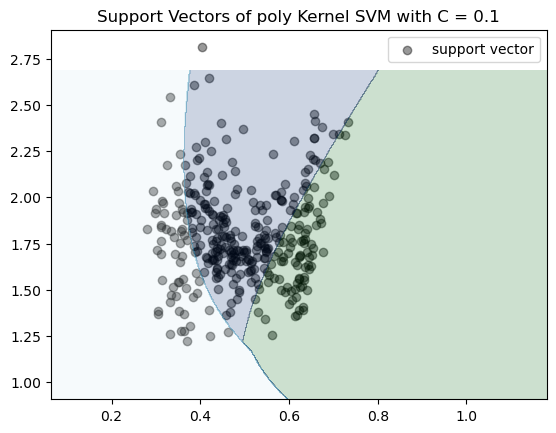

Using a  poly  kernel with C =  10
Accuracy on the training set:  0.8003597122302158
Accuracy on the test set:  0.7490774907749077


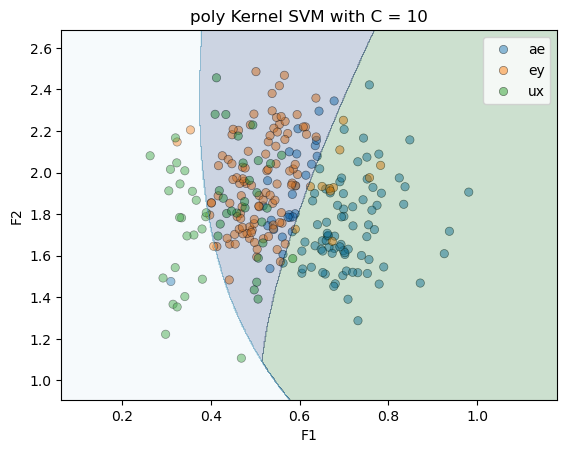

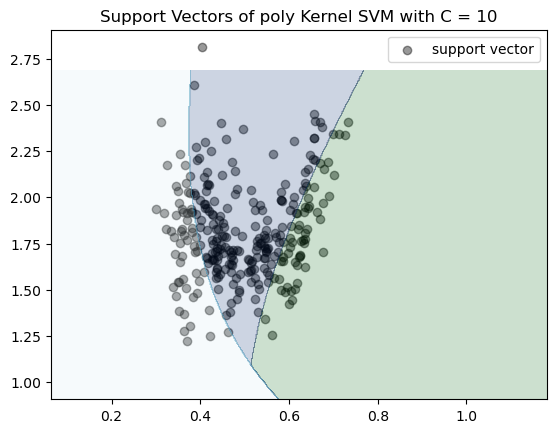

Using a  poly  kernel with C =  100
Accuracy on the training set:  0.7949640287769785
Accuracy on the test set:  0.7453874538745388


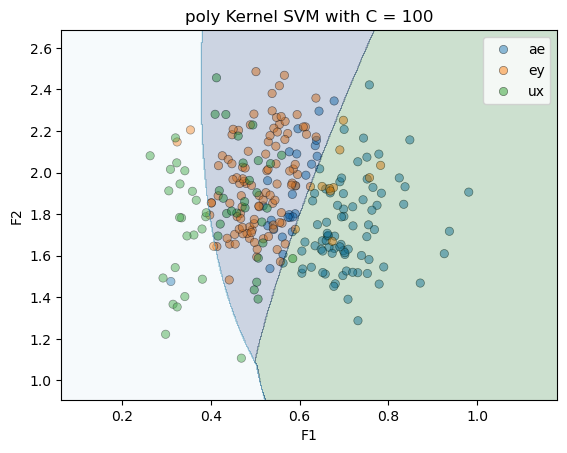

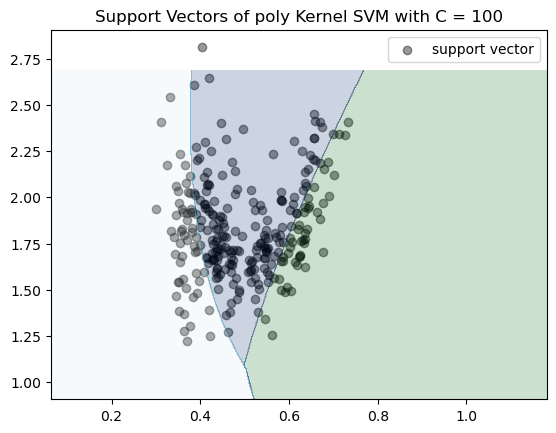

Using a  poly  kernel with C =  1000
Accuracy on the training set:  0.7949640287769785
Accuracy on the test set:  0.7416974169741697


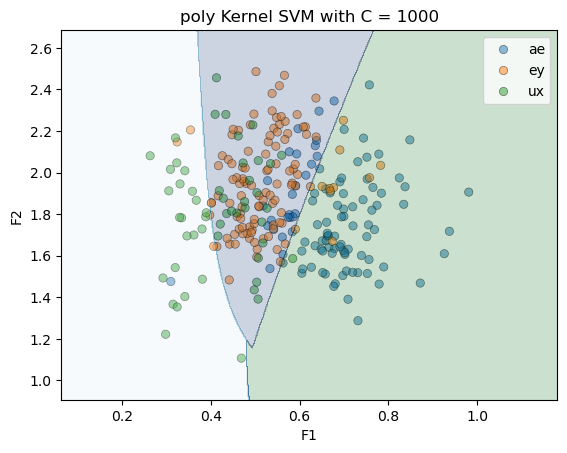

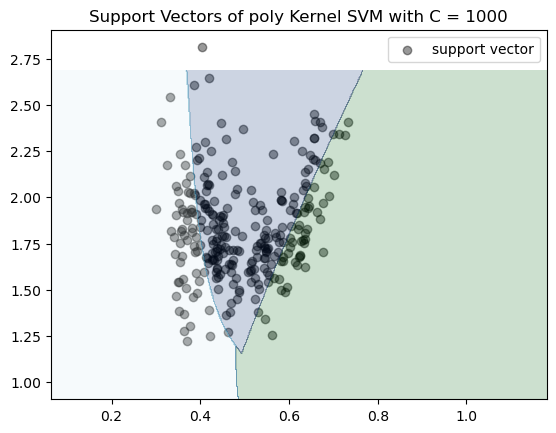

In [32]:
def TrainTestPlotDecisionRegionsAndSupportVectors(kernel, c, training_set, training_labels, testing_set, testing_labels):
    cls = SVC(kernel=kernel, C=c, decision_function_shape='ovo')
    cls.fit(training_set, training_labels)
    pred_cls = cls.predict(testing_set)
    pred_cls_training = cls.predict(training_set)
    print("Using a ", kernel, " kernel with C = ", c)
    print("Accuracy on the training set: ", accuracy_score(training_labels, pred_cls_training))
    print("Accuracy on the test set: ", accuracy_score(testing_labels, pred_cls))
    PlotSVMDecisionRegions(cls, testing_set, testing_labels_phonemes, title = kernel + " Kernel SVM with C = " + str(c))
    PlotSupportVectors(cls, testing_set, testing_labels_phonemes, title = "Support Vectors of " + kernel + " Kernel SVM with C = " + str(c))

TrainTestPlotDecisionRegionsAndSupportVectors('poly', 0.1, training_set, training_labels, testing_set, testing_labels)
TrainTestPlotDecisionRegionsAndSupportVectors('poly', 10, training_set, training_labels, testing_set, testing_labels)
TrainTestPlotDecisionRegionsAndSupportVectors('poly', 100, training_set, training_labels, testing_set, testing_labels)
TrainTestPlotDecisionRegionsAndSupportVectors('poly', 1000, training_set, training_labels, testing_set, testing_labels)

As we can see, the accuray when using the polynomial kernel remains fairly constant when increasing C. This is most likely due to the fact that the polynomial kernel is already a very good fit for the data. This is both the case for the prediction on the training set and test set.

When the polynomial kernel is a good fit, there is little to no difference in changing the focus between large margin and low error.

The performance on the training set is always higher than the performance on the test set. This is expected, since the model is trained on the training set, but it is only giving a 5% higher accuray.

Also testing the same C's using a Sigmoid kernel:

Using a  sigmoid  kernel with C =  0.1
Accuracy on the training set:  0.5089928057553957
Accuracy on the test set:  0.42066420664206644


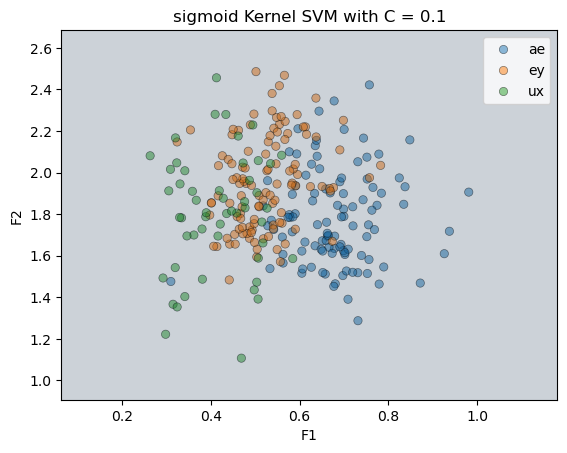

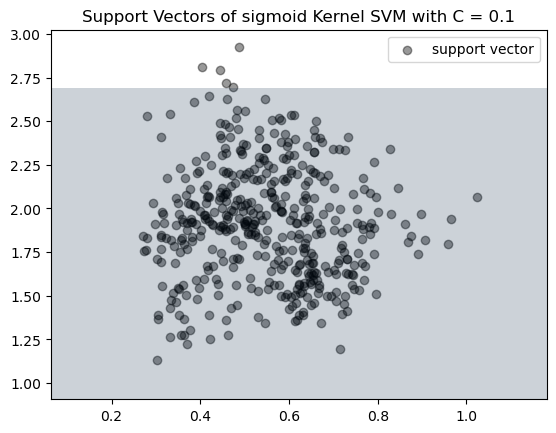

Using a  sigmoid  kernel with C =  10
Accuracy on the training set:  0.35431654676258995
Accuracy on the test set:  0.33948339483394835


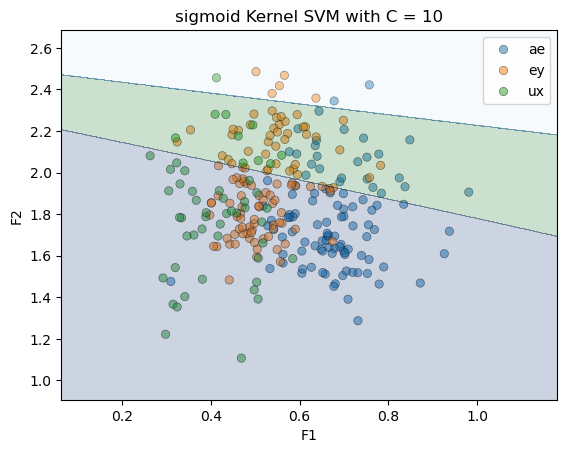

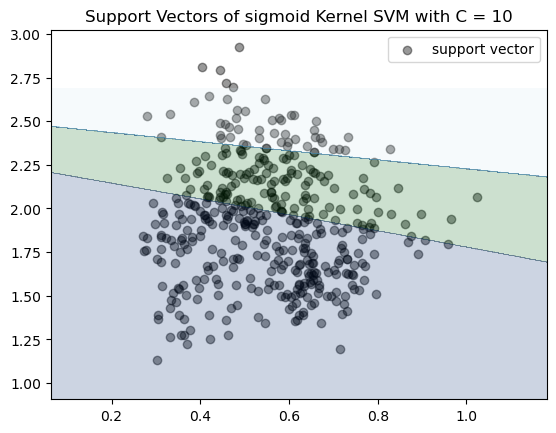

Using a  sigmoid  kernel with C =  100
Accuracy on the training set:  0.4136690647482014
Accuracy on the test set:  0.4095940959409594


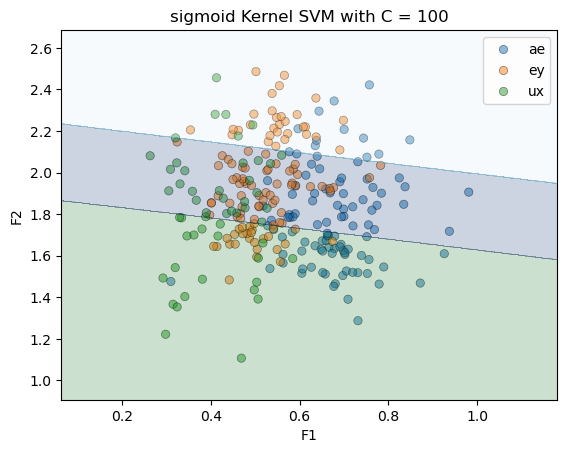

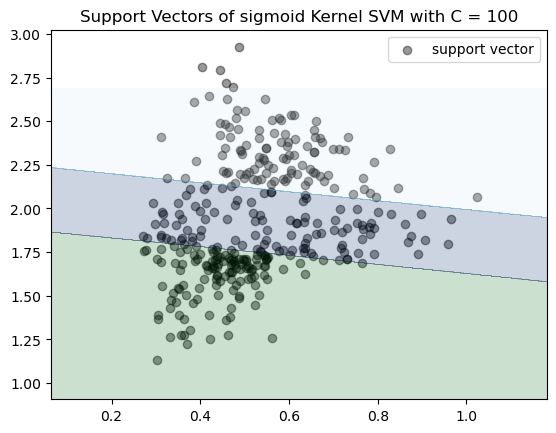

Using a  sigmoid  kernel with C =  1000
Accuracy on the training set:  0.4028776978417266
Accuracy on the test set:  0.4095940959409594


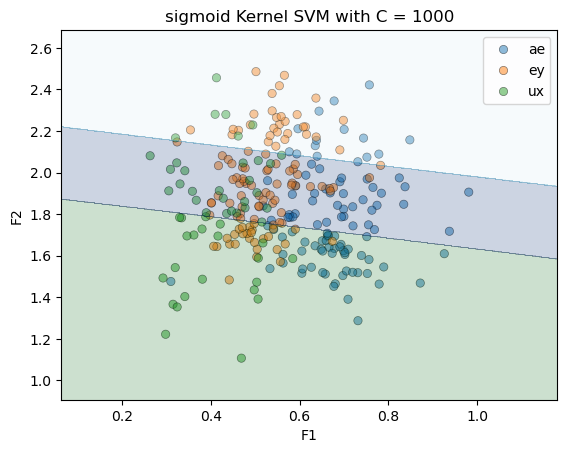

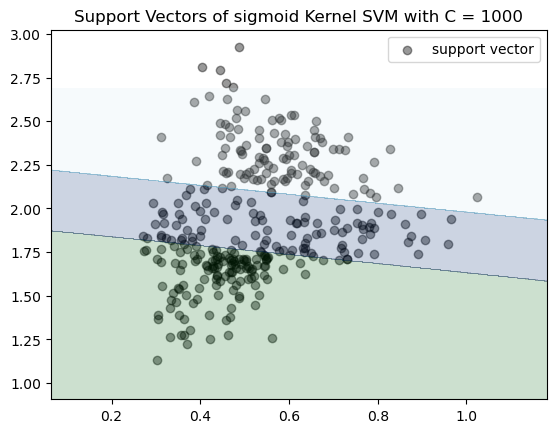

In [33]:
TrainTestPlotDecisionRegionsAndSupportVectors('sigmoid', 0.1, training_set, training_labels, testing_set, testing_labels)
TrainTestPlotDecisionRegionsAndSupportVectors('sigmoid', 10, training_set, training_labels, testing_set, testing_labels)
TrainTestPlotDecisionRegionsAndSupportVectors('sigmoid', 100, training_set, training_labels, testing_set, testing_labels)
TrainTestPlotDecisionRegionsAndSupportVectors('sigmoid', 1000, training_set, training_labels, testing_set, testing_labels)

The performance using the sigmoid kernel is the best when using a penalty term C = 0.1 or C = 1.

Also testing the same C's using a RBF kernel:

Using a  rbf  kernel with C =  0.1
Accuracy on the training set:  0.697841726618705
Accuracy on the test set:  0.6494464944649446


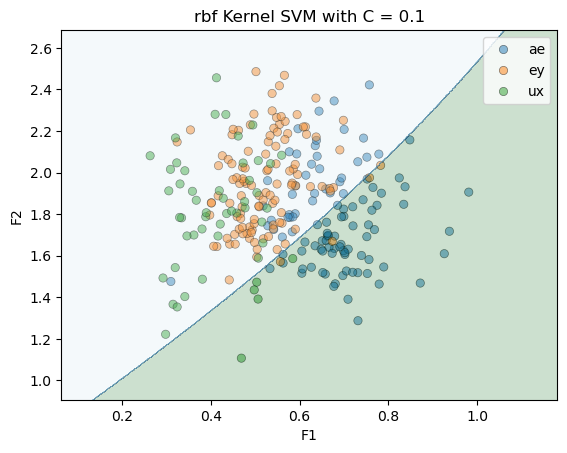

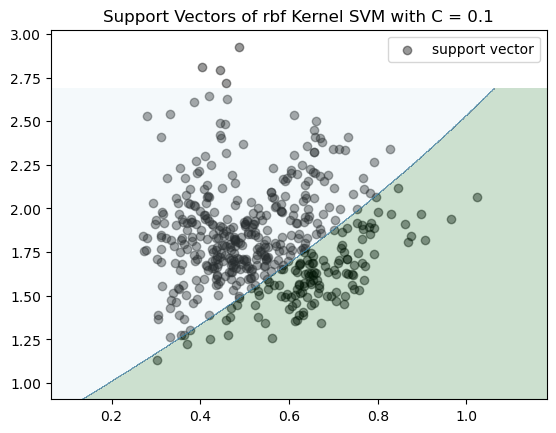

Using a  rbf  kernel with C =  10
Accuracy on the training set:  0.8057553956834532
Accuracy on the test set:  0.7490774907749077


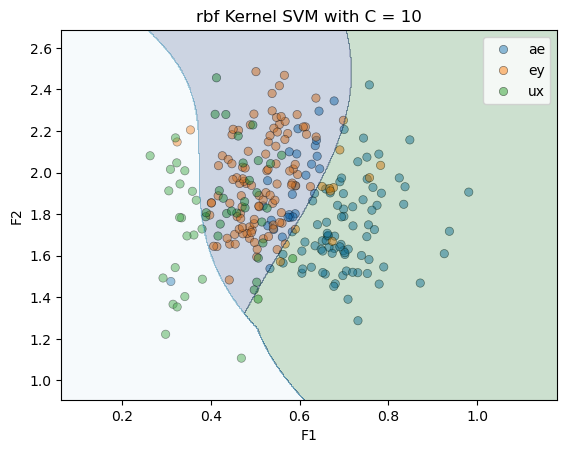

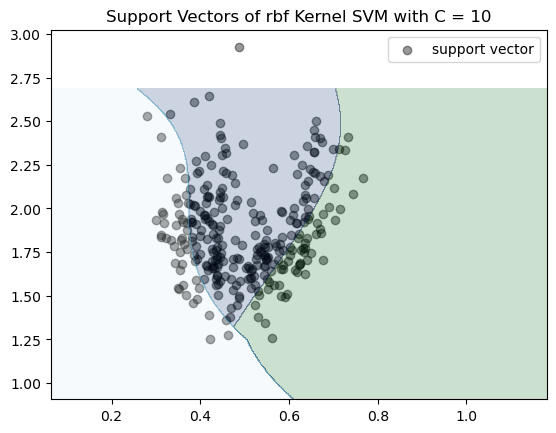

Using a  rbf  kernel with C =  100
Accuracy on the training set:  0.814748201438849
Accuracy on the test set:  0.7453874538745388


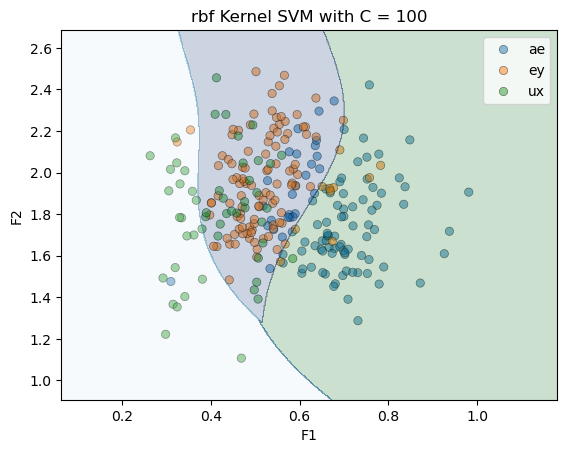

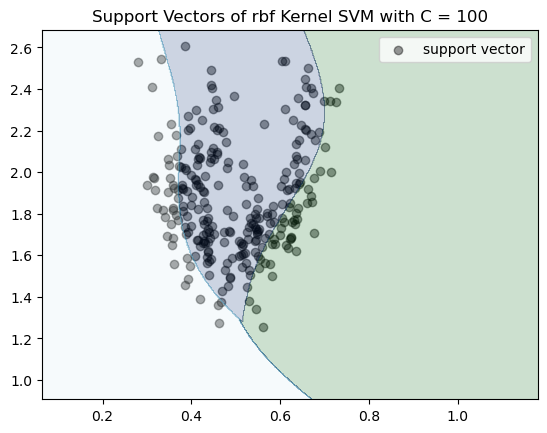

Using a  rbf  kernel with C =  1000
Accuracy on the training set:  0.8183453237410072
Accuracy on the test set:  0.7416974169741697


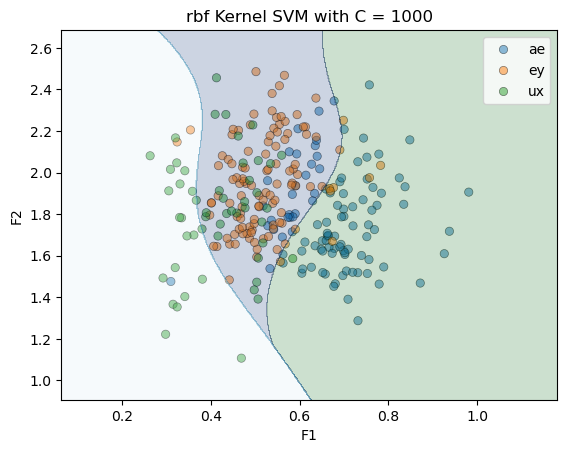

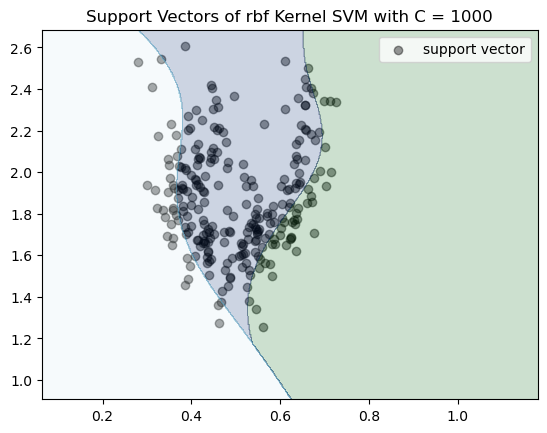

In [34]:
TrainTestPlotDecisionRegionsAndSupportVectors('rbf', 0.1, training_set, training_labels, testing_set, testing_labels)
TrainTestPlotDecisionRegionsAndSupportVectors('rbf', 10, training_set, training_labels, testing_set, testing_labels)
TrainTestPlotDecisionRegionsAndSupportVectors('rbf', 100, training_set, training_labels, testing_set, testing_labels)
TrainTestPlotDecisionRegionsAndSupportVectors('rbf', 1000, training_set, training_labels, testing_set, testing_labels)

The performance using the RBF kernel increases with the penalty terms, but converges to around 81% for C > 10.

The performance using the sigmoid kernel is overall a worse model. This is most likely due to the fact that the sigmoid kernel is not a good fit for the data.